# Code to group the TC GPI as per the MJO phases (based on the rMII index of MJO) for the Monsoon Onset period 

# NCSU Tropical Dynamics 
# June 2023
# A. Aiyyer and S. Dhavale

In [33]:
import re
from datetime import date, datetime

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import geocat.viz as gv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter

In [34]:
def plot_GPI(GPI,latS,latN,lonW,lonE,minC,maxC,intC,colormap):
 
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
    from geocat.viz import util as gvutil
    from shapely.geometry.polygon import LinearRing

    levC = int((maxC-minC)/intC) + 1

# Generate figure (set its size (width, height) in inches)
    fig = plt.figure(figsize=(18,8))

# Generate axes, using Cartopy, drawing coastlines, and adding features
    projection = ccrs.PlateCarree()

    ax = plt.axes(projection=projection)
    ax.coastlines(linewidths=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Import an NCL colormap
    #newcmp = gvcmaps.BlAqGrYeOrRe
    #newcmp = 'YlOrBr'  #'YlGn' #'coolwarm'  #gvcmaps.ncl_default
    #newcmp = gvcmaps.BlAqGrYeOrRe
    #cmap =  'PuOr_r' # reversed colors using _r

    
    contourLevels = np.arange(minC, maxC, intC)
    vmaxMap = GPI.plot.contourf(ax=ax,
                          transform=projection,
                          vmin=minC,
                          vmax=maxC,
                          levels=contourLevels,
                          cmap=colormap,
                          add_colorbar=False)


    gvutil.set_axes_limits_and_ticks(ax,
                                     xlim=(lonW, lonE),
                                     ylim=(latS, latN),
                                     xticks=np.linspace(lonW,lonE , 6),
                                     yticks=np.linspace(latS, latN,3))
    
    
     # Use geocat.viz.util convenience function to add minor and major tick lines
    gvutil.add_major_minor_ticks(ax)

  
    # Use geocat.viz.util convenience function to add titles
    gv.set_titles_and_labels(ax,
                         lefttitle='GPI',
                         righttitle=' ',
                         lefttitlefontsize=12,
                         righttitlefontsize=12)
  
    
    # Use geocat.viz.util convenience function to make latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)
    # Remove degree symbol from tick labels
    
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
    
    
    # Do not label (title) the lat and lon axis
    ax.set(xlabel=None)
    ax.set(ylabel=None)

    # Add colorbar
    cbar = plt.colorbar(vmaxMap, orientation='horizontal',fraction=0.1,
                        ticks=np.arange(minC, maxC, intC),
                        shrink=0.75,pad=0.15,
                        extendrect=True,extendfrac='auto')
    
    return ax
#cbar.ax.set_yticklabels([str(i) for i in np.arange(minC, maxC, intC)])
#cbar.ax.set_yticklabels(str(conto

In [35]:
# first set the years and months for the processing
# we shall allow for seclecting specific range of dates within each year


year_start  = 1982
month_start = 5
day_start   = 5

year_end  = 2021
month_end = 6
day_end   = 20

date_series = [pd.date_range(date(i,month_start,day_start),date(i,month_end,day_end), freq ='D') for i in range(year_start,year_end+1)]
# date_series is a list of lists. Lets unpack it now
dates_list = [element for sublist in date_series for element in sublist]

In [36]:
len(dates_list)
#date_series

1880

In [37]:
#Now read the MOV data

mov_file = 'mov_formation_ibtracs_imd_final.ascii'
mov = pd.read_csv (mov_file,delim_whitespace=True)
mov['date'] = pd.to_datetime(mov['date'], format='%Y%m%d', errors='coerce')

In [38]:
#Now reading the RMII Index file


rmii_file = 'rMII_index_latest.txt'

rmii = pd.read_csv (rmii_file,skiprows=1,header=None,delim_whitespace=True)
rmii.columns = ['year', 'month', 'day', 'RMII1', 'RMII2', 'phase_original']

rmii1 = rmii.RMII1
rmii2 = rmii.RMII2

amplitude = np.sqrt(rmii1*rmii1 + rmii2*rmii2)

print(amplitude)

# combine the year month and day to get a date:
rmii['date'] = pd.to_datetime(rmii[['year', 'month', 'day']])
rmii.drop(columns=['year', 'month', 'day'], inplace=True)

#rmii.assign(amplitude=amplitude)
rmii['amplitude'] = amplitude



# Now replace the phase corresponding to amplitudes < 1 with phase=0
# Now we have phase=0 for weak MJO events

print(rmii)

rmii.columns = ['RMII1', 'RMII2', 'phase_original', 'date', 'amplitude']

rmii['phase'] = rmii.phase_original.where(rmii.amplitude>1, 0)

# a quick look at the phases that got replaced
# print(rmii[rmii.phase==0].to_string())
rmii.head(n=50)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
16122    NaN
16123    NaN
16124    NaN
16125    NaN
16126    NaN
Length: 16127, dtype: float64
       RMII1  RMII2       phase_original       date  amplitude
0        0.0    0.0                    5 1979-01-01        0.0
1        0.0    0.0                    5 1979-01-02        0.0
2        0.0    0.0                    5 1979-01-03        0.0
3        0.0    0.0                    5 1979-01-04        0.0
4        0.0    0.0                    5 1979-01-05        0.0
...      ...    ...                  ...        ...        ...
16122    NaN    NaN -9223372036854775808 2023-02-21        NaN
16123    NaN    NaN -9223372036854775808 2023-02-22        NaN
16124    NaN    NaN -9223372036854775808 2023-02-23        NaN
16125    NaN    NaN -9223372036854775808 2023-02-24        NaN
16126    NaN    NaN -9223372036854775808 2023-02-25        NaN

[16127 rows x 5 columns]


,RMII1,RMII2,phase_original,date,amplitude,phase
0,0.00000,0.00000,5,1979-01-01,0.000000,0
1,0.00000,0.00000,5,1979-01-02,0.000000,0
2,0.00000,0.00000,5,1979-01-03,0.000000,0
3,0.00000,0.00000,5,1979-01-04,0.000000,0
4,0.00000,0.00000,5,1979-01-05,0.000000,0
5,0.00000,0.00000,5,1979-01-06,0.000000,0
6,0.00000,0.00000,5,1979-01-07,0.000000,0
7,0.00000,0.00000,5,1979-01-08,0.000000,0
8,0.00000,0.00000,5,1979-01-09,0.000000,0
9,0.00000,0.00000,5,1979-01-10,0.000000,0


In [39]:
# now subset the rmm for only the premonsoon dates
rmii_subset = rmii[rmii.date.isin(dates_list)].reset_index()

# create a new pandas dataframe that will hold the RMM info for
# the MOV dates: D0,P1,M1  --> day0, day+1, day-1

mov_phase = pd.DataFrame()
mov_phase['phase_D0'] = rmii[rmii['date'].isin(mov.date)].reset_index().phase
mov_phase['phase_P1'] = rmii[rmii['date'].isin(mov.date +  pd.Timedelta(1, "d"))].reset_index().phase
mov_phase['phase_M1'] = rmii[rmii['date'].isin(mov.date +  pd.Timedelta(-1, "d"))].reset_index().phase
mov_phase[ ['date', 'lon', 'lat'] ] = mov[ ['date','lon','lat'] ]

In [40]:
rmii_subset

,index,RMII1,RMII2,phase_original,date,amplitude,phase
0,1220,-0.00088,0.68787,7,1982-05-05,0.687871,0
1,1221,-0.09604,0.80893,7,1982-05-06,0.814611,0
2,1222,-0.21874,0.91016,7,1982-05-07,0.936076,0
3,1223,-0.31896,0.96880,7,1982-05-08,1.019955,7
4,1224,-0.40454,0.99841,7,1982-05-09,1.077254,7
...,...,...,...,...,...,...,...
1875,15507,-0.58574,-0.19342,1,2021-06-16,0.616849,0
1876,15508,-0.65578,-0.15912,1,2021-06-17,0.674809,0
1877,15509,-0.72427,-0.14158,1,2021-06-18,0.737978,0
1878,15510,-0.83696,-0.07796,1,2021-06-19,0.840583,0


In [41]:
#Read the GPI data calculated earlier

# kotal gpp
#dataDir = '/glade/scratch/aiyyer/data/kgpp_gpi/'
#fileNames =[dataDir + 'kgpp' + fn.strftime('%Y%m%d')+ '.nc' for fn in dates_list]


# EN GPI
#dataDir = '/glade/scratch/aiyyer/data/era5_EN_GPI/'
dataDir = '/glade/work/aiyyer/era5_EN_GPI/'
fileNames =[dataDir + 'EN' + fn.strftime('%Y%m%d')+ '.nc' for fn in dates_list]


GP_index = 'GPI'    # 'GPI' KGPP
#GP_index = 'KGPP'    # 'GPI' KGPP

In [42]:
# since the GPI files do not have a time dimension, we will need to expand the 
# dimensions for the xr.open.mfdataset to correctly join the daily files

# define a preprocess function where we extract the time info from the filename

def preprocess(ds):
    # include a dummy path
    var = next(var for var in ds)
    path=ds[var].encoding['source']
    match_str = re.search(r'\d{4}\d{2}\d{2}', str(path))
    time = pd.to_datetime(datetime.strptime(match_str.group(), '%Y%m%d'))
    return ds.assign_coords(time = [time])

# now read all the files in parallel
ds = xr.open_mfdataset(fileNames, preprocess=preprocess,  combine='nested' , concat_dim='time', parallel=True)

In [43]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 181, time: 1880)
Coordinates:
  * latitude   (latitude) float64 30.0 29.75 29.5 29.25 ... 0.75 0.5 0.25 0.0
  * longitude  (longitude) float64 40.0 40.25 40.5 40.75 ... 84.5 84.75 85.0
  * time       (time) datetime64[ns] 1982-05-05 1982-05-06 ... 2021-06-20
Data variables:
    GPI        (time, latitude, longitude) float32 dask.array<chunksize=(1, 121, 181), meta=np.ndarray>

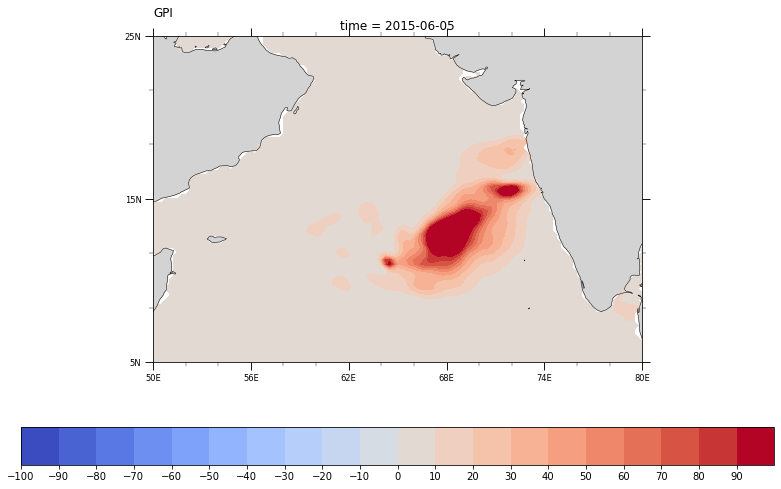

In [44]:
# plot anom for one day
minC = -20
maxC =  20
intC =  2.

minC = -100
maxC =  100
intC =  10.



minlon =  50.
maxlon =  80.
minlat =   5.
maxlat =   25.
colormap='coolwarm'
ax=plot_GPI(ds.GPI.sel(time='2015-06-05'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
#ax=plot_GPI(ds.KGPP.sel(time='1983-06-05'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)


plt.show()

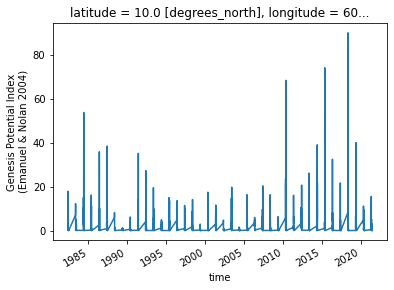

In [45]:
# read the GPI index and replace nan with zero for kotal gpp
GP = ds[GP_index].fillna(0.)


#GP = ds[GP_index]

# a quick peek
GP.sel(longitude=60.,latitude=10.).plot()

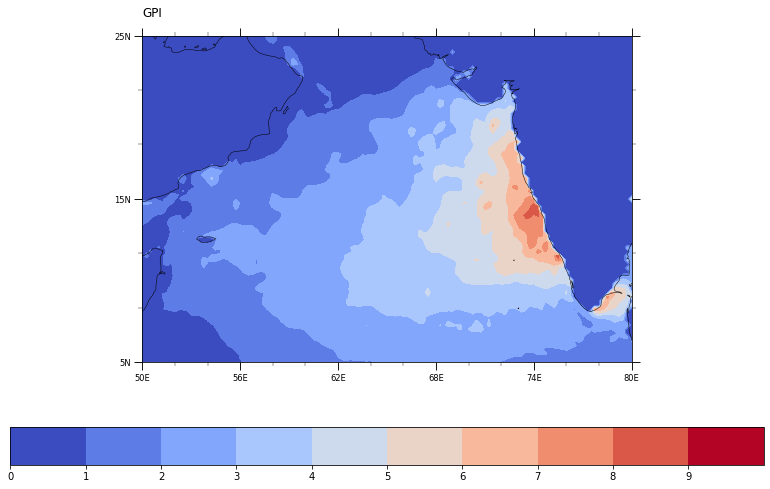

In [46]:
minC = 0
maxC = 10
intC = 1.

minlon =  50.
maxlon =  80.
minlat =   5.
maxlat =   25.

colormap='coolwarm'

ax=plot_GPI(GP.mean(dim='time'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)

plt.show()

In [47]:
print (GP.mean(dim='time').min().values, GP.mean(dim='time').max().values)
print (GP.median(dim='time').min().values, GP.median(dim='time').max().values)
print (GP.min().values, GP.max().values)

0.0 10.001375
0.0 6.196171
-1.0135971e-07 3837.2039


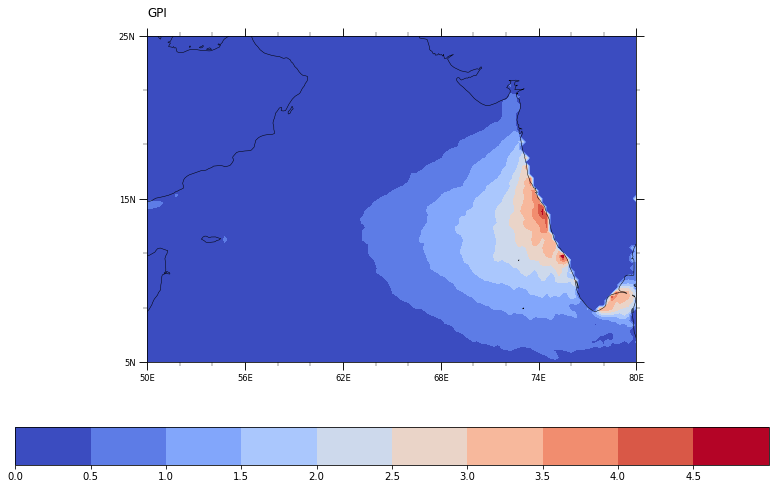

In [48]:
minC = 0
maxC = 5
intC = .5

minlon =  50.
maxlon =  80.
minlat =   5.
maxlat =   25.

colormap='coolwarm'

ax=plot_GPI(GP.median(dim='time'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)

plt.show()

In [49]:
#To calcualte daily anomalies from a daily long-term mean, first groupby day of year
#And then calcualate the daily longterm mean climo

# group the data by day and calculate the long-term mean (LTM) climatology
gb = GP.groupby(ds.time.dt.dayofyear)

#print( gb.count(dim='time').sel(longitude=60.,latitude=10.).values )
#ic = 0
#for d1,d2 in zip(ds.time.dt.dayofyear.values, ds.time.values):
#    if ( d1 == 132):
#        ic = ic + 1
#        print (ic, d1,d2)


In [50]:
clim = gb.mean(dim='time')

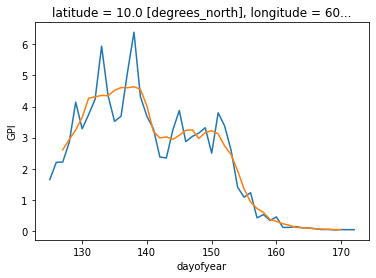

In [51]:
window_days = 2
climS = clim.rolling(dayofyear=window_days*2+1, center=True).mean()

clim.sel(longitude=60.,latitude=10.).plot()
climS.sel(longitude=60.,latitude=10.).plot()

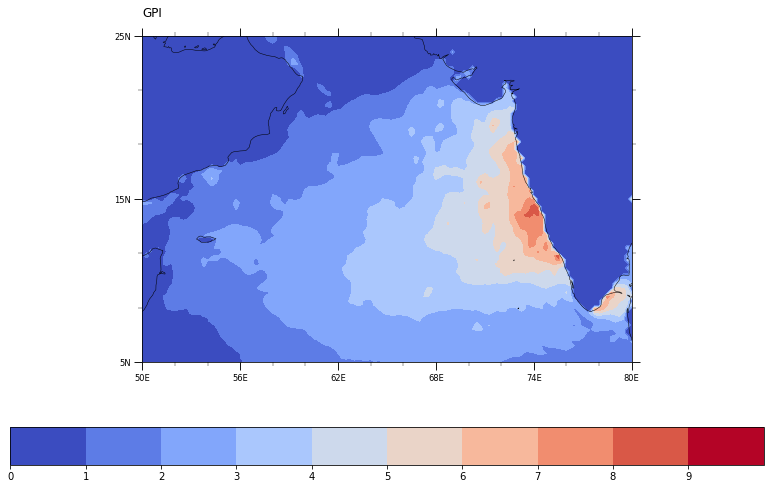

In [52]:
# quick peek at the mean over all days
minC = 0
maxC = 10
intC = 1.
ax=plot_GPI(clim.mean(dim='dayofyear'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)

In [53]:
anom  =  gb-climS

/glade/u/apps/opt/conda/envs/npl/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


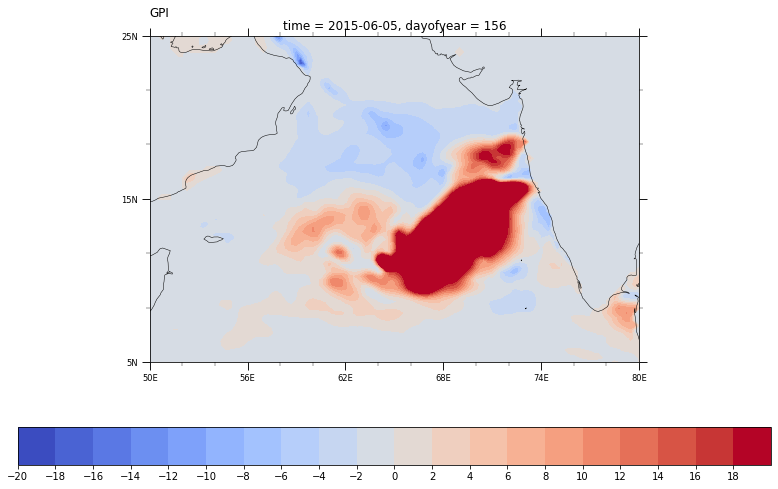

In [54]:
# plot anom for one day
minC = -20
maxC =  20
intC =  2.
colormap='coolwarm'
ax=plot_GPI(anom.sel(time='2015-06-05'),minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
plt.show()

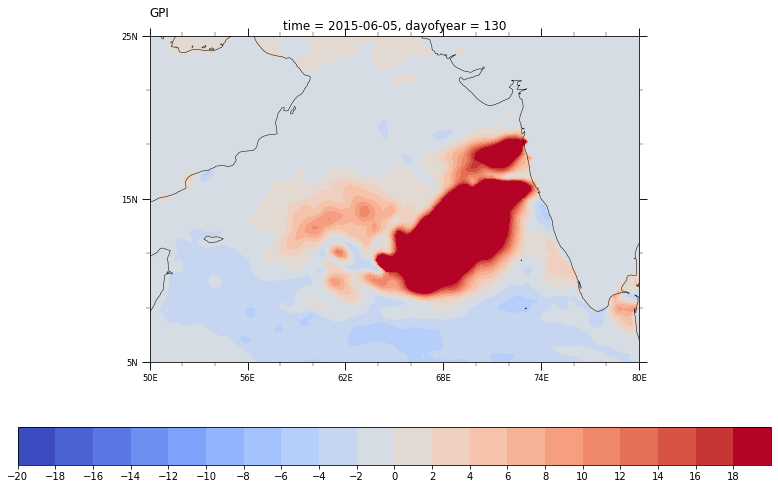

In [55]:
# confirm anom is being calcualated correctly
# fig below should be identical to one above
data = GP.sel(time='2015-06-05') - clim.sel(dayofyear=130)
ax=plot_GPI(data,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
plt.show()

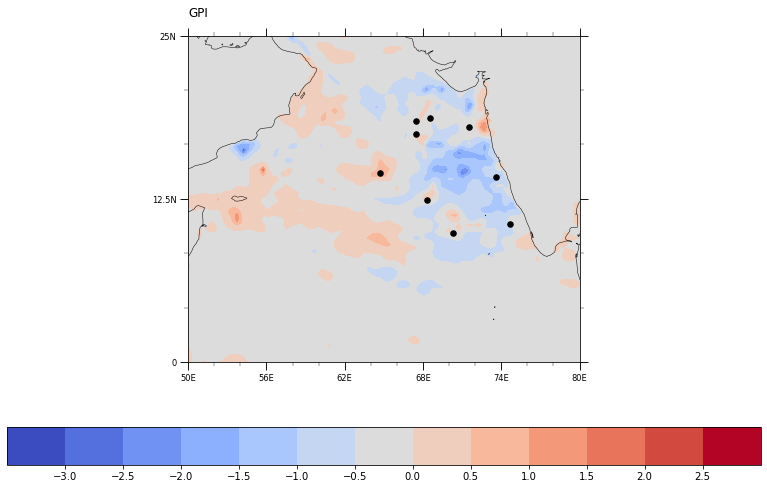

In [56]:
minlon =  50.
maxlon =  80.
minlat =   0.
maxlat =   25.
minC = -3
maxC =  3
intC =  .5

zero_phases = [0]
dates_zero = rmii_subset[rmii_subset.phase.isin(zero_phases)].date.values
GP_zero  = anom.sel(time=dates_zero).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(zero_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(zero_phases)].lat

colormap='coolwarm'


ax=plot_GPI(GP_zero,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
ax.scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')

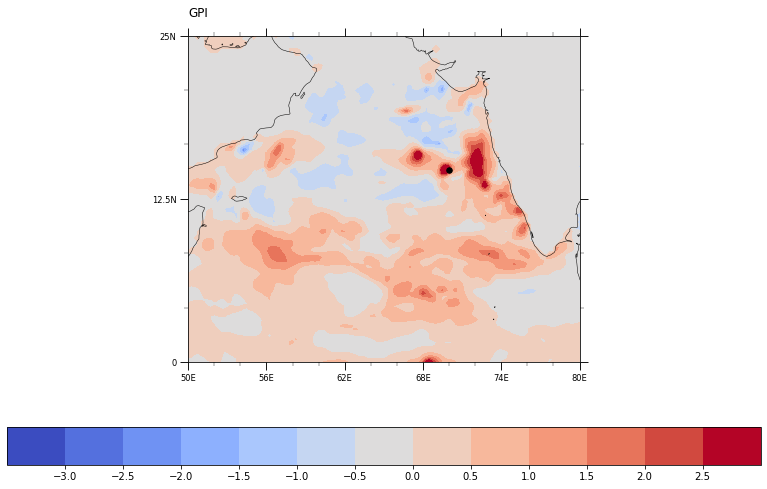

In [57]:
minlon =  50.
maxlon =  80.
minlat =   0.
maxlat =   25.
minC = -3
maxC =  3
intC =  .5

transition_phases = [1,5]
dates_transition = rmii_subset[rmii_subset.phase.isin(transition_phases)].date.values
GP_transition  = anom.sel(time=dates_transition).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(transition_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(transition_phases)].lat

colormap='coolwarm'


ax=plot_GPI(GP_transition,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
ax.scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')

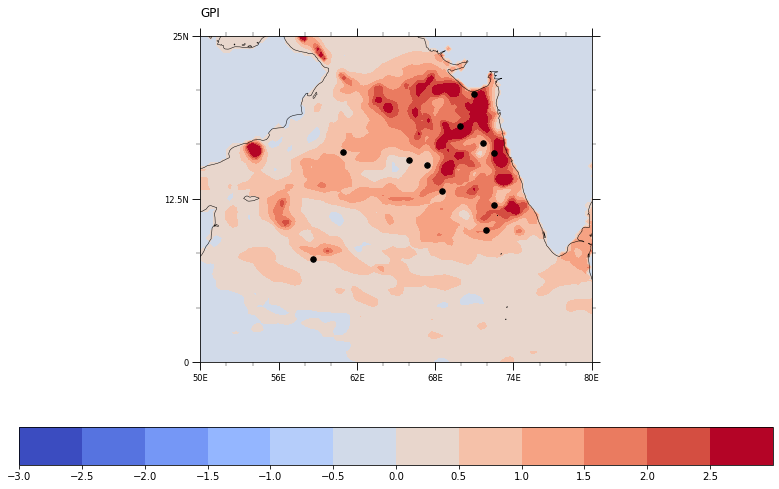

In [58]:
convec_phases = [2,3,4]
dates_convec = rmii_subset[rmii_subset.phase.isin(convec_phases)].date.values
GP_convec  = anom.sel(time=dates_convec).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(convec_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(convec_phases)].lat

colormap='coolwarm'


ax=plot_GPI(GP_convec,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
ax.scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')

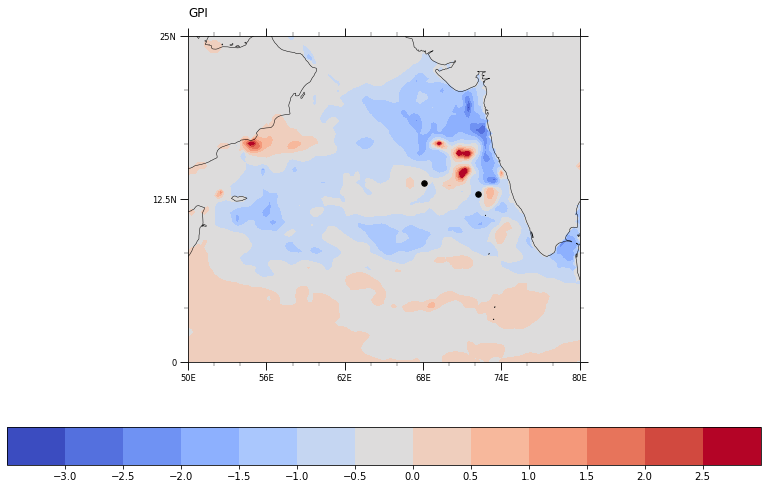

In [59]:
supres_phases = [6,7,8]
dates_supres = rmii_subset[rmii_subset.phase.isin(supres_phases)].date.values
GP_supres  = anom.sel(time=dates_supres).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(supres_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(supres_phases)].lat

colormap='coolwarm'


ax=plot_GPI(GP_supres,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
ax.scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')

0.5898643921809285 0.0
-0.1247563052382043


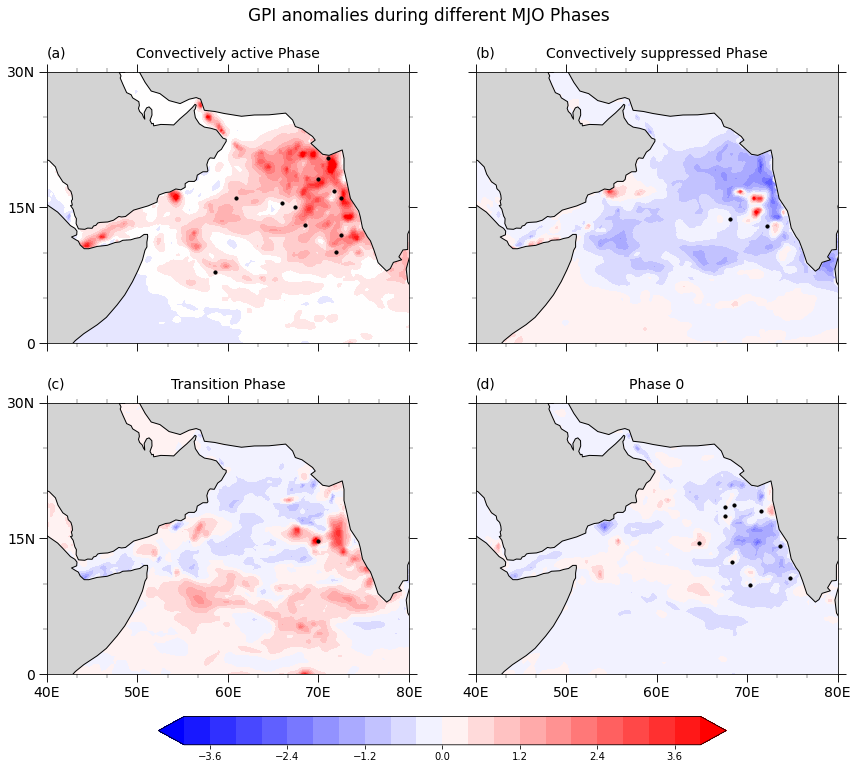

In [60]:
#Plotting a 2x2 panel plot for GP anomalies

minlon =  40.
maxlon =  80.
minlat =   0.
maxlat =   30.

#minC = -3
#maxC =  3
#intC =  .3

projection = ccrs.PlateCarree()
fig, ax = plt.subplots(2,
                       2,
                       layout="constrained",
                       gridspec_kw={'wspace': 0.06, 'hspace': 0.07},
                       subplot_kw={"projection": projection})

#constrained_layout=True,
# Set figure size (width, height) in inches
fig.set_size_inches((12,10))

# Add continents
continents = cartopy.feature.NaturalEarthFeature(name="coastline",
                                                 category="physical",
                                                 scale="110m",
                                                 edgecolor="black",
                                                 facecolor="lightgray")
[axes.add_feature(continents) for axes in ax.flat]


colormap='bwr'

# Specify which contour levels to draw
contour_lev = np.arange(-4,4.4, 0.4)

#ax[0]=plot_GPI(GP_supres,minlat,maxlat,minlon,maxlon,minC,maxC,intC,colormap)
#ax[0].scatter(lons,lats,s=30,transform=ccrs.PlateCarree(), facecolor='black')


# landsea mask

era5_invar_dir = '/glade/collections/rda/data/ds633.0/e5.oper.invariant/197901/'
fname = era5_invar_dir + 'e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
dslsm  = xr.open_dataset(fname)   

latS=0
latN=30
lonW=40
lonE=80

lsm = dslsm.LSM[0,:,:].sel(latitude=slice(latN,latS), longitude=slice(lonW,lonE))

# Using a dictionary makes it easy to reuse the same keyword arguments twice for the contours
kwargs = dict(xlim=(minlon, maxlon),
              ylim=(minlat, maxlat),
              xticks=np.linspace(minlon, maxlon, 5),
              yticks=np.linspace(minlat, maxlat,3),
              transform=projection,  # ds projection
              add_colorbar=False,  # don't add individual colorbars for each plot call
              add_labels=False,  # turn off xarray's automatic Lat, lon labels
)


GP_convec  = anom.sel(time=dates_convec).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(convec_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(convec_phases)].lat

#GP_convec = GP_convec.where(lsm==0)   # apply the land-sea mask

GPconvec_plot = GP_convec.plot.contourf(ax=ax[0,0],levels=contour_lev,cmap=colormap,**kwargs)
ax[0,0].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[0,0].set_title('Convectively active Phase',fontsize=14,y=1.03)
ax[0,0].set_title('(a)',loc='left',fontsize=14,y=1.03)


GP_supres  = anom.sel(time=dates_supres).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(supres_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(supres_phases)].lat

#GP_supres= GP_supres.where(lsm==0)   # apply the land-sea mask

GPsupres_plot = GP_supres.plot.contourf(ax=ax[0,1],levels=contour_lev,cmap=colormap,extend='both',**kwargs)
ax[0,1].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[0,1].set_title('Convectively suppressed Phase',fontsize=14,y=1.03)
ax[0,1].set_title('(b)',loc='left',fontsize=14,y=1.03)


GP_transition  = anom.sel(time=dates_transition).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(transition_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(transition_phases)].lat

#GP_transition = GP_transition.where(lsm==0)   # apply the land-sea mask

GPtransition_plot = GP_transition.plot.contourf(ax=ax[1,0],levels=contour_lev,cmap=colormap,extend='both',**kwargs)
ax[1,0].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[1,0].set_title('Transition Phase',fontsize=14,y=1.03)
ax[1,0].set_title('(c)',loc='left',fontsize=14,y=1.03)


GP_zero  = anom.sel(time=dates_zero).mean(dim='time') 
lons = mov_phase[mov_phase['phase_D0'].isin(zero_phases)].lon
lats = mov_phase[mov_phase['phase_D0'].isin(zero_phases)].lat

#GP_zero = GP_zero.where(lsm==0)   # apply the land-sea mask

GP0_plot = GP_zero.plot.contourf(ax=ax[1,1],levels=contour_lev,cmap=colormap, extend='both',**kwargs)
ax[1,1].scatter(lons,lats,s=10,transform=ccrs.PlateCarree(), facecolor='black')
ax[1,1].set_title('Phase 0',fontsize=14,y=1.03)
ax[1,1].set_title('(d)',loc='left',fontsize=14,y=1.03)



fig.suptitle('GPI anomalies during different MJO Phases',fontsize=17, y=1.05)

#fig.suptitle('KGPP anomalies during different MJO Phases',fontsize=16)
#for row in range(2):

#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig.colorbar(GPtransition_plot, ax=ax[1, :], shrink=0.7, location='bottom')    #extend='both' 

#fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0.2,
#                            wspace=0.2)

#plt.subplots_adjust(hspace=-0.1,wspace=0.15)

#print(GP_zero)
print(GP_zero.sel(latitude=15,longitude=65).values, GP_zero.sel(latitude=20,longitude=75).values)
print(GP_supres.sel(latitude=24,longitude=63).values)

for ax in ax.flat:
    gv.add_major_minor_ticks(ax,labelsize=14)
    gv.add_lat_lon_ticklabels(ax)
    ax.label_outer()
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
    
#fig.tight_layout()